In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn

# Local imports
from model import GraphAttentionNetwork
from utils.dataset import DrugProteinDataset
from utils.helper_functions import set_seeds, accuracy_func, plot_loss_curves

In [18]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [19]:
def train_model(args) -> None:
    set_seeds()

    model = GraphAttentionNetwork(
        333, 1, 16,
        args['hidden_size'],
        args['num_layers'],
        args['num_attn_heads']
    ).to(device)

    train_dataset, validation_dataset, test_dataset = load_data(
        args['data_path'], args['seed'],
        args['frac_train'], args['frac_validation'], args['frac_test'],
        args['use_small_dataset']
    )
    
    train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=args['batch_size'], shuffle=False)

    loss_func = nn.SmoothL1Loss(beta=args['huber_beta'])
    optimizer = optim.AdamW(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=args['scheduler_factor'], patience=args['scheduler_patience'])

    best_validation_loss = float('inf')
    no_validation_loss_improvement = 0
    metrics_df = pd.DataFrame(columns=['train_loss', 'validation_loss'], index=range(args['max_epochs']))

    for epoch in range(args['max_epochs']):
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{args['max_epochs']}", leave=True)
        avg_train_loss, avg_train_acc = run_training_epoch(progress_bar, optimizer, model, loss_func)
        avg_validation_loss, avg_validation_acc = get_validation_metrics(validation_loader, model, loss_func)

        lr_scheduler.step(avg_train_loss)

        metrics_df.at[epoch, 'train_loss'] = avg_train_loss
        metrics_df.at[epoch, 'validation_loss'] = avg_validation_loss
        metrics_df.at[epoch, 'train_acc'] = avg_train_acc
        metrics_df.at[epoch, 'validation_acc'] = avg_validation_acc

        print(f"Epoch {epoch + 1}: Train Loss = {avg_train_loss:.5f}, Validation Loss = {avg_validation_loss:.5f}, "
              f"Train Acc = {avg_train_acc:.5f}, Validation Acc = {avg_validation_acc:.5f}")

        if avg_validation_loss < best_validation_loss:
            best_validation_loss = avg_validation_loss
            no_validation_loss_improvement = 0
            torch.save(model.state_dict(), '../models/model.pth')
        else:
            no_validation_loss_improvement += 1
            if no_validation_loss_improvement == args['stoppage_epochs']:
                break

    plot_loss_curves(metrics_df)


In [ ]:
def run_training_epoch(progress_bar, optimizer, model, loss_func):
    model.train()
    cum_samples = cum_loss = cum_acc = 0

    for batch_data in progress_bar:
        node_features, edge_features, adjacency_matrix, pchembl_score = [
            x.to(torch.float32).to(device) for x in batch_data
        ]

        preds = model(node_features, edge_features, adjacency_matrix).squeeze(-1)
        loss = loss_func(preds, pchembl_score)

        cum_samples += preds.shape[0]
        cum_loss += loss.item() * preds.shape[0]
        cum_acc += accuracy_func(preds, pchembl_score, threshold=7.0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return cum_loss / cum_samples, cum_acc / cum_samples


In [21]:
def get_validation_metrics(loader, model, loss_func):
    model.eval()
    cum_samples = cum_loss = cum_acc = 0

    for batch in loader:
        node_features, edge_features, adjacency_matrix, pchembl_scores = [
            x.to(torch.float32).to(device) for x in batch
        ]

        preds = model(node_features, edge_features, adjacency_matrix).squeeze(-1)
        loss = loss_func(preds, pchembl_scores).item()
        acc = accuracy_func(preds, pchembl_scores, threshold=7.0)

        cum_samples += preds.shape[0]
        cum_loss += loss * preds.shape[0]
        cum_acc += acc

    return cum_loss / cum_samples, cum_acc / cum_samples


In [22]:
def load_data(data_path, seed, frac_train, frac_val, frac_test, use_small):
    assert math.isclose(frac_train + frac_val + frac_test, 1), "Splits must sum to 1"

    file_name = 'filtered_cancer_small.csv' if use_small else 'filtered_cancer_all.csv'
    data_df = pd.read_csv(f'{data_path}/{file_name}')
    protein_df = pd.read_csv(f'{data_path}/protein_embeddings.csv', index_col=0)

    data_df['stratify_col'] = data_df['Target_ID'] + '_' + data_df['label'].astype(str)

    train_df, remain_df = train_test_split(data_df, test_size=frac_val + frac_test,
                                           stratify=data_df['stratify_col'], random_state=seed)
    val_df, test_df = train_test_split(remain_df, test_size=frac_test / (frac_val + frac_test),
                                       stratify=remain_df['stratify_col'], random_state=seed)

    train_df = train_df.drop(columns='stratify_col')
    val_df = val_df.drop(columns='stratify_col')
    test_df = test_df.drop(columns='stratify_col')

    train_set = DrugProteinDataset(train_df, protein_df)
    val_set = DrugProteinDataset(val_df, protein_df)
    test_set = DrugProteinDataset(test_df, protein_df)

    return train_set, val_set, test_set


In [23]:
args = {
    "use_small_dataset": True,
    "batch_size": 64,
    "stoppage_epochs": 128,
    "max_epochs": 128,
    "seed": 42,
    "data_path": "../data",
    "frac_train": 0.7,
    "frac_validation": 0.15,
    "frac_test": 0.15,
    "huber_beta": 1.0,
    "weight_decay": 1e-4,
    "lr": 3e-3,
    "scheduler_patience": 10,
    "scheduler_factor": 0.5,
    "hidden_size": 32,
    "num_layers": 4,
    "num_attn_heads": 8,
    "dropout": 0.2,
    "leaky_relu_slope": 0.2
}


Epoch 1/128: 100%|██████████| 55/55 [00:06<00:00,  9.03it/s]


Epoch 1: Train Loss = 1.24800, Validation Loss = 0.73201, Train Acc = 0.63916, Validation Acc = 0.66534


Epoch 2/128: 100%|██████████| 55/55 [00:05<00:00,  9.87it/s]


Epoch 2: Train Loss = 0.59678, Validation Loss = 0.64412, Train Acc = 0.66335, Validation Acc = 0.66534


Epoch 3/128: 100%|██████████| 55/55 [00:05<00:00,  9.85it/s]


Epoch 3: Train Loss = 0.56870, Validation Loss = 0.58434, Train Acc = 0.67786, Validation Acc = 0.66534


Epoch 4/128: 100%|██████████| 55/55 [00:05<00:00,  9.85it/s]


Epoch 4: Train Loss = 0.57531, Validation Loss = 0.54227, Train Acc = 0.67501, Validation Acc = 0.67995


Epoch 5/128: 100%|██████████| 55/55 [00:05<00:00,  9.85it/s]


Epoch 5: Train Loss = 0.56190, Validation Loss = 0.55915, Train Acc = 0.68469, Validation Acc = 0.67463


Epoch 6/128: 100%|██████████| 55/55 [00:05<00:00,  9.83it/s]


Epoch 6: Train Loss = 0.56925, Validation Loss = 0.54538, Train Acc = 0.67758, Validation Acc = 0.67596


Epoch 7/128: 100%|██████████| 55/55 [00:05<00:00,  9.84it/s]


Epoch 7: Train Loss = 0.56734, Validation Loss = 0.53492, Train Acc = 0.67388, Validation Acc = 0.69057


Epoch 8/128: 100%|██████████| 55/55 [00:05<00:00,  9.83it/s]


Epoch 8: Train Loss = 0.54831, Validation Loss = 0.53133, Train Acc = 0.68241, Validation Acc = 0.68127


Epoch 9/128: 100%|██████████| 55/55 [00:05<00:00,  9.84it/s]


Epoch 9: Train Loss = 0.55720, Validation Loss = 0.52977, Train Acc = 0.68497, Validation Acc = 0.68393


Epoch 10/128: 100%|██████████| 55/55 [00:05<00:00,  9.85it/s]


Epoch 10: Train Loss = 0.54124, Validation Loss = 0.52921, Train Acc = 0.68810, Validation Acc = 0.68659


Epoch 11/128: 100%|██████████| 55/55 [00:05<00:00,  9.85it/s]


Epoch 11: Train Loss = 0.54039, Validation Loss = 0.56632, Train Acc = 0.68981, Validation Acc = 0.68260


Epoch 12/128: 100%|██████████| 55/55 [00:05<00:00,  9.85it/s]


Epoch 12: Train Loss = 0.54536, Validation Loss = 0.52572, Train Acc = 0.68583, Validation Acc = 0.68659


Epoch 13/128: 100%|██████████| 55/55 [00:05<00:00,  9.84it/s]


Epoch 13: Train Loss = 0.54357, Validation Loss = 0.54511, Train Acc = 0.68526, Validation Acc = 0.69190


Epoch 14/128: 100%|██████████| 55/55 [00:05<00:00,  9.81it/s]


Epoch 14: Train Loss = 0.53635, Validation Loss = 0.50775, Train Acc = 0.69067, Validation Acc = 0.69323


Epoch 15/128: 100%|██████████| 55/55 [00:05<00:00,  9.78it/s]


Epoch 15: Train Loss = 0.53265, Validation Loss = 0.51097, Train Acc = 0.69465, Validation Acc = 0.68659


Epoch 16/128: 100%|██████████| 55/55 [00:05<00:00,  9.75it/s]


Epoch 16: Train Loss = 0.54333, Validation Loss = 0.51303, Train Acc = 0.68640, Validation Acc = 0.68127


Epoch 17/128: 100%|██████████| 55/55 [00:05<00:00,  9.77it/s]


Epoch 17: Train Loss = 0.52969, Validation Loss = 0.51082, Train Acc = 0.69493, Validation Acc = 0.69057


Epoch 18/128: 100%|██████████| 55/55 [00:05<00:00,  9.81it/s]


Epoch 18: Train Loss = 0.51931, Validation Loss = 0.51987, Train Acc = 0.70091, Validation Acc = 0.68792


Epoch 19/128: 100%|██████████| 55/55 [00:05<00:00,  9.78it/s]


Epoch 19: Train Loss = 0.52793, Validation Loss = 0.51704, Train Acc = 0.68497, Validation Acc = 0.69854


Epoch 20/128: 100%|██████████| 55/55 [00:05<00:00,  9.82it/s]


Epoch 20: Train Loss = 0.53048, Validation Loss = 0.50955, Train Acc = 0.69180, Validation Acc = 0.68127


Epoch 21/128: 100%|██████████| 55/55 [00:05<00:00,  9.87it/s]


Epoch 21: Train Loss = 0.52710, Validation Loss = 0.50582, Train Acc = 0.69522, Validation Acc = 0.69456


Epoch 22/128: 100%|██████████| 55/55 [00:05<00:00,  9.87it/s]


Epoch 22: Train Loss = 0.53236, Validation Loss = 0.54698, Train Acc = 0.69636, Validation Acc = 0.68127


Epoch 23/128: 100%|██████████| 55/55 [00:05<00:00,  9.84it/s]


Epoch 23: Train Loss = 0.52752, Validation Loss = 0.54487, Train Acc = 0.69323, Validation Acc = 0.68659


Epoch 24/128: 100%|██████████| 55/55 [00:05<00:00,  9.83it/s]


Epoch 24: Train Loss = 0.52910, Validation Loss = 0.54844, Train Acc = 0.68839, Validation Acc = 0.68659


Epoch 25/128: 100%|██████████| 55/55 [00:05<00:00,  9.85it/s]


Epoch 25: Train Loss = 0.53384, Validation Loss = 0.52304, Train Acc = 0.69550, Validation Acc = 0.67729


Epoch 26/128: 100%|██████████| 55/55 [00:05<00:00,  9.88it/s]


Epoch 26: Train Loss = 0.52633, Validation Loss = 0.51177, Train Acc = 0.69209, Validation Acc = 0.68659


Epoch 27/128: 100%|██████████| 55/55 [00:05<00:00,  9.88it/s]


Epoch 27: Train Loss = 0.52699, Validation Loss = 0.50051, Train Acc = 0.69266, Validation Acc = 0.70252


Epoch 28/128: 100%|██████████| 55/55 [00:05<00:00,  9.89it/s]


Epoch 28: Train Loss = 0.52896, Validation Loss = 0.52277, Train Acc = 0.68327, Validation Acc = 0.68659


Epoch 29/128: 100%|██████████| 55/55 [00:05<00:00,  9.86it/s]


Epoch 29: Train Loss = 0.52283, Validation Loss = 0.49674, Train Acc = 0.69180, Validation Acc = 0.69057


Epoch 30/128: 100%|██████████| 55/55 [00:05<00:00,  9.82it/s]


Epoch 30: Train Loss = 0.51428, Validation Loss = 0.55560, Train Acc = 0.69465, Validation Acc = 0.68659


Epoch 31/128: 100%|██████████| 55/55 [00:05<00:00,  9.84it/s]


Epoch 31: Train Loss = 0.51173, Validation Loss = 0.49417, Train Acc = 0.69892, Validation Acc = 0.68924


Epoch 32/128: 100%|██████████| 55/55 [00:05<00:00,  9.85it/s]


Epoch 32: Train Loss = 0.50786, Validation Loss = 0.49955, Train Acc = 0.69920, Validation Acc = 0.68924


Epoch 33/128: 100%|██████████| 55/55 [00:05<00:00,  9.90it/s]


Epoch 33: Train Loss = 0.51392, Validation Loss = 0.49344, Train Acc = 0.69806, Validation Acc = 0.69456


Epoch 34/128: 100%|██████████| 55/55 [00:05<00:00,  9.86it/s]


Epoch 34: Train Loss = 0.52464, Validation Loss = 0.50277, Train Acc = 0.70120, Validation Acc = 0.69588


Epoch 35/128: 100%|██████████| 55/55 [00:05<00:00,  9.90it/s]


Epoch 35: Train Loss = 0.51482, Validation Loss = 0.49609, Train Acc = 0.69607, Validation Acc = 0.69456


Epoch 36/128: 100%|██████████| 55/55 [00:05<00:00,  9.88it/s]


Epoch 36: Train Loss = 0.51631, Validation Loss = 0.50898, Train Acc = 0.70546, Validation Acc = 0.68924


Epoch 37/128: 100%|██████████| 55/55 [00:05<00:00,  9.90it/s]


Epoch 37: Train Loss = 0.51331, Validation Loss = 0.50131, Train Acc = 0.69038, Validation Acc = 0.69323


Epoch 38/128: 100%|██████████| 55/55 [00:05<00:00,  9.90it/s]


Epoch 38: Train Loss = 0.50517, Validation Loss = 0.51865, Train Acc = 0.70546, Validation Acc = 0.68792


Epoch 39/128: 100%|██████████| 55/55 [00:05<00:00,  9.90it/s]


Epoch 39: Train Loss = 0.51672, Validation Loss = 0.51856, Train Acc = 0.69294, Validation Acc = 0.68393


Epoch 40/128: 100%|██████████| 55/55 [00:05<00:00,  9.91it/s]


Epoch 40: Train Loss = 0.50814, Validation Loss = 0.51872, Train Acc = 0.70660, Validation Acc = 0.68792


Epoch 41/128: 100%|██████████| 55/55 [00:05<00:00,  9.91it/s]


Epoch 41: Train Loss = 0.52851, Validation Loss = 0.58394, Train Acc = 0.69664, Validation Acc = 0.67862


Epoch 42/128: 100%|██████████| 55/55 [00:05<00:00,  9.90it/s]


Epoch 42: Train Loss = 0.52336, Validation Loss = 0.51744, Train Acc = 0.69721, Validation Acc = 0.68526


Epoch 43/128: 100%|██████████| 55/55 [00:05<00:00,  9.91it/s]


Epoch 43: Train Loss = 0.51283, Validation Loss = 0.49285, Train Acc = 0.70319, Validation Acc = 0.69987


Epoch 44/128: 100%|██████████| 55/55 [00:05<00:00,  9.83it/s]


Epoch 44: Train Loss = 0.50164, Validation Loss = 0.49189, Train Acc = 0.70660, Validation Acc = 0.69588


Epoch 45/128: 100%|██████████| 55/55 [00:05<00:00,  9.78it/s]


Epoch 45: Train Loss = 0.50317, Validation Loss = 0.52884, Train Acc = 0.70290, Validation Acc = 0.68792


Epoch 46/128: 100%|██████████| 55/55 [00:05<00:00,  9.83it/s]


Epoch 46: Train Loss = 0.51114, Validation Loss = 0.62509, Train Acc = 0.70632, Validation Acc = 0.68526


Epoch 47/128: 100%|██████████| 55/55 [00:05<00:00,  9.76it/s]


Epoch 47: Train Loss = 0.51764, Validation Loss = 0.55938, Train Acc = 0.70489, Validation Acc = 0.68127


Epoch 48/128: 100%|██████████| 55/55 [00:05<00:00,  9.89it/s]


Epoch 48: Train Loss = 0.51042, Validation Loss = 0.51253, Train Acc = 0.70063, Validation Acc = 0.70252


Epoch 49/128: 100%|██████████| 55/55 [00:05<00:00,  9.84it/s]


Epoch 49: Train Loss = 0.51346, Validation Loss = 0.50221, Train Acc = 0.69863, Validation Acc = 0.69057


Epoch 50/128: 100%|██████████| 55/55 [00:05<00:00,  9.89it/s]


Epoch 50: Train Loss = 0.51049, Validation Loss = 0.51204, Train Acc = 0.70091, Validation Acc = 0.69854


Epoch 51/128: 100%|██████████| 55/55 [00:05<00:00,  9.86it/s]


Epoch 51: Train Loss = 0.51041, Validation Loss = 0.48465, Train Acc = 0.70176, Validation Acc = 0.70784


Epoch 52/128: 100%|██████████| 55/55 [00:05<00:00,  9.89it/s]


Epoch 52: Train Loss = 0.51784, Validation Loss = 0.48544, Train Acc = 0.70120, Validation Acc = 0.70252


Epoch 53/128: 100%|██████████| 55/55 [00:05<00:00,  9.89it/s]


Epoch 53: Train Loss = 0.50714, Validation Loss = 0.50235, Train Acc = 0.70660, Validation Acc = 0.69190


Epoch 54/128: 100%|██████████| 55/55 [00:05<00:00,  9.87it/s]


Epoch 54: Train Loss = 0.51380, Validation Loss = 0.51346, Train Acc = 0.69237, Validation Acc = 0.69057


Epoch 55/128: 100%|██████████| 55/55 [00:05<00:00,  9.79it/s]


Epoch 55: Train Loss = 0.51306, Validation Loss = 0.50945, Train Acc = 0.69209, Validation Acc = 0.69854


Epoch 56/128: 100%|██████████| 55/55 [00:05<00:00,  9.86it/s]


Epoch 56: Train Loss = 0.49865, Validation Loss = 0.52055, Train Acc = 0.69778, Validation Acc = 0.69190


Epoch 57/128: 100%|██████████| 55/55 [00:05<00:00,  9.85it/s]


Epoch 57: Train Loss = 0.50148, Validation Loss = 0.47751, Train Acc = 0.70518, Validation Acc = 0.71315


Epoch 58/128: 100%|██████████| 55/55 [00:05<00:00,  9.83it/s]


Epoch 58: Train Loss = 0.50515, Validation Loss = 0.48072, Train Acc = 0.70148, Validation Acc = 0.69456


Epoch 59/128: 100%|██████████| 55/55 [00:05<00:00,  9.81it/s]


Epoch 59: Train Loss = 0.50682, Validation Loss = 0.48695, Train Acc = 0.70006, Validation Acc = 0.69588


Epoch 60/128: 100%|██████████| 55/55 [00:05<00:00,  9.81it/s]


Epoch 60: Train Loss = 0.49929, Validation Loss = 0.49537, Train Acc = 0.71059, Validation Acc = 0.69721


Epoch 61/128: 100%|██████████| 55/55 [00:05<00:00,  9.80it/s]


Epoch 61: Train Loss = 0.50080, Validation Loss = 0.49789, Train Acc = 0.70603, Validation Acc = 0.70385


Epoch 62/128: 100%|██████████| 55/55 [00:05<00:00,  9.82it/s]


Epoch 62: Train Loss = 0.50199, Validation Loss = 0.48394, Train Acc = 0.70376, Validation Acc = 0.70252


Epoch 63/128: 100%|██████████| 55/55 [00:05<00:00,  9.85it/s]


Epoch 63: Train Loss = 0.49561, Validation Loss = 0.47123, Train Acc = 0.70945, Validation Acc = 0.72908


Epoch 64/128: 100%|██████████| 55/55 [00:05<00:00,  9.89it/s]


Epoch 64: Train Loss = 0.50493, Validation Loss = 0.50360, Train Acc = 0.70546, Validation Acc = 0.69987


Epoch 65/128: 100%|██████████| 55/55 [00:05<00:00,  9.89it/s]


Epoch 65: Train Loss = 0.49837, Validation Loss = 0.48102, Train Acc = 0.70689, Validation Acc = 0.70252


Epoch 66/128: 100%|██████████| 55/55 [00:05<00:00,  9.90it/s]


Epoch 66: Train Loss = 0.49666, Validation Loss = 0.50063, Train Acc = 0.70774, Validation Acc = 0.70120


Epoch 67/128: 100%|██████████| 55/55 [00:05<00:00,  9.89it/s]


Epoch 67: Train Loss = 0.49921, Validation Loss = 0.48357, Train Acc = 0.70546, Validation Acc = 0.71049


Epoch 68/128: 100%|██████████| 55/55 [00:05<00:00,  9.89it/s]


Epoch 68: Train Loss = 0.50367, Validation Loss = 0.48019, Train Acc = 0.70461, Validation Acc = 0.71448


Epoch 69/128: 100%|██████████| 55/55 [00:05<00:00,  9.89it/s]


Epoch 69: Train Loss = 0.49359, Validation Loss = 0.49742, Train Acc = 0.71144, Validation Acc = 0.70120


Epoch 70/128: 100%|██████████| 55/55 [00:05<00:00,  9.90it/s]


Epoch 70: Train Loss = 0.50530, Validation Loss = 0.51483, Train Acc = 0.69920, Validation Acc = 0.69456


Epoch 71/128: 100%|██████████| 55/55 [00:05<00:00,  9.89it/s]


Epoch 71: Train Loss = 0.50331, Validation Loss = 0.46994, Train Acc = 0.70290, Validation Acc = 0.71448


Epoch 72/128: 100%|██████████| 55/55 [00:05<00:00,  9.85it/s]


Epoch 72: Train Loss = 0.49210, Validation Loss = 0.47902, Train Acc = 0.71286, Validation Acc = 0.70916


Epoch 73/128: 100%|██████████| 55/55 [00:05<00:00,  9.86it/s]


Epoch 73: Train Loss = 0.49160, Validation Loss = 0.47588, Train Acc = 0.71656, Validation Acc = 0.70651


Epoch 74/128: 100%|██████████| 55/55 [00:05<00:00,  9.83it/s]


Epoch 74: Train Loss = 0.49961, Validation Loss = 0.47073, Train Acc = 0.71201, Validation Acc = 0.70916


Epoch 75/128: 100%|██████████| 55/55 [00:05<00:00,  9.85it/s]


Epoch 75: Train Loss = 0.50012, Validation Loss = 0.47523, Train Acc = 0.70489, Validation Acc = 0.70784


Epoch 76/128: 100%|██████████| 55/55 [00:05<00:00,  9.87it/s]


Epoch 76: Train Loss = 0.49466, Validation Loss = 0.48721, Train Acc = 0.71599, Validation Acc = 0.70916


Epoch 77/128: 100%|██████████| 55/55 [00:05<00:00,  9.86it/s]


Epoch 77: Train Loss = 0.50227, Validation Loss = 0.46885, Train Acc = 0.71229, Validation Acc = 0.69987


Epoch 78/128: 100%|██████████| 55/55 [00:05<00:00,  9.84it/s]


Epoch 78: Train Loss = 0.48717, Validation Loss = 0.47148, Train Acc = 0.71372, Validation Acc = 0.71979


Epoch 79/128: 100%|██████████| 55/55 [00:05<00:00,  9.84it/s]


Epoch 79: Train Loss = 0.50015, Validation Loss = 0.50020, Train Acc = 0.70973, Validation Acc = 0.69854


Epoch 80/128: 100%|██████████| 55/55 [00:05<00:00,  9.84it/s]


Epoch 80: Train Loss = 0.49669, Validation Loss = 0.49089, Train Acc = 0.71400, Validation Acc = 0.71448


Epoch 81/128: 100%|██████████| 55/55 [00:05<00:00,  9.83it/s]


Epoch 81: Train Loss = 0.49428, Validation Loss = 0.48174, Train Acc = 0.70888, Validation Acc = 0.70916


Epoch 82/128: 100%|██████████| 55/55 [00:05<00:00,  9.88it/s]


Epoch 82: Train Loss = 0.49800, Validation Loss = 0.46605, Train Acc = 0.71372, Validation Acc = 0.71979


Epoch 83/128: 100%|██████████| 55/55 [00:05<00:00,  9.88it/s]


Epoch 83: Train Loss = 0.49688, Validation Loss = 0.47341, Train Acc = 0.71884, Validation Acc = 0.70916


Epoch 84/128: 100%|██████████| 55/55 [00:05<00:00,  9.87it/s]


Epoch 84: Train Loss = 0.49102, Validation Loss = 0.47017, Train Acc = 0.71343, Validation Acc = 0.71979


Epoch 85/128: 100%|██████████| 55/55 [00:05<00:00,  9.87it/s]


Epoch 85: Train Loss = 0.49117, Validation Loss = 0.46637, Train Acc = 0.71485, Validation Acc = 0.71049


Epoch 86/128: 100%|██████████| 55/55 [00:05<00:00,  9.87it/s]


Epoch 86: Train Loss = 0.49177, Validation Loss = 0.48617, Train Acc = 0.71400, Validation Acc = 0.70784


Epoch 87/128: 100%|██████████| 55/55 [00:05<00:00,  9.82it/s]


Epoch 87: Train Loss = 0.49171, Validation Loss = 0.46759, Train Acc = 0.71912, Validation Acc = 0.71315


Epoch 88/128: 100%|██████████| 55/55 [00:05<00:00,  9.83it/s]


Epoch 88: Train Loss = 0.49279, Validation Loss = 0.46560, Train Acc = 0.72197, Validation Acc = 0.72112


Epoch 89/128: 100%|██████████| 55/55 [00:05<00:00,  9.82it/s]


Epoch 89: Train Loss = 0.48841, Validation Loss = 0.47451, Train Acc = 0.71713, Validation Acc = 0.70651


Epoch 90/128: 100%|██████████| 55/55 [00:05<00:00,  9.87it/s]


Epoch 90: Train Loss = 0.48650, Validation Loss = 0.45971, Train Acc = 0.72595, Validation Acc = 0.73440


Epoch 91/128: 100%|██████████| 55/55 [00:05<00:00,  9.87it/s]


Epoch 91: Train Loss = 0.49064, Validation Loss = 0.50092, Train Acc = 0.72083, Validation Acc = 0.71182


Epoch 92/128: 100%|██████████| 55/55 [00:05<00:00,  9.87it/s]


Epoch 92: Train Loss = 0.49273, Validation Loss = 0.48335, Train Acc = 0.70262, Validation Acc = 0.70784


Epoch 93/128: 100%|██████████| 55/55 [00:05<00:00,  9.87it/s]


Epoch 93: Train Loss = 0.49736, Validation Loss = 0.47229, Train Acc = 0.71229, Validation Acc = 0.71846


Epoch 94/128: 100%|██████████| 55/55 [00:05<00:00,  9.86it/s]


Epoch 94: Train Loss = 0.48306, Validation Loss = 0.47454, Train Acc = 0.71827, Validation Acc = 0.72112


Epoch 95/128: 100%|██████████| 55/55 [00:05<00:00,  9.83it/s]


Epoch 95: Train Loss = 0.48372, Validation Loss = 0.46693, Train Acc = 0.72254, Validation Acc = 0.71049


Epoch 96/128: 100%|██████████| 55/55 [00:05<00:00,  9.83it/s]


Epoch 96: Train Loss = 0.48123, Validation Loss = 0.47153, Train Acc = 0.72425, Validation Acc = 0.72112


Epoch 97/128: 100%|██████████| 55/55 [00:05<00:00,  9.86it/s]


Epoch 97: Train Loss = 0.48793, Validation Loss = 0.46093, Train Acc = 0.72339, Validation Acc = 0.71846


Epoch 98/128: 100%|██████████| 55/55 [00:05<00:00,  9.86it/s]


Epoch 98: Train Loss = 0.49461, Validation Loss = 0.47724, Train Acc = 0.71514, Validation Acc = 0.72244


Epoch 99/128: 100%|██████████| 55/55 [00:05<00:00,  9.86it/s]


Epoch 99: Train Loss = 0.48755, Validation Loss = 0.46434, Train Acc = 0.71542, Validation Acc = 0.72112


Epoch 100/128: 100%|██████████| 55/55 [00:05<00:00,  9.87it/s]


Epoch 100: Train Loss = 0.48818, Validation Loss = 0.45980, Train Acc = 0.72823, Validation Acc = 0.72643


Epoch 101/128: 100%|██████████| 55/55 [00:05<00:00,  9.84it/s]


Epoch 101: Train Loss = 0.49461, Validation Loss = 0.46483, Train Acc = 0.71030, Validation Acc = 0.72112


Epoch 102/128: 100%|██████████| 55/55 [00:05<00:00,  9.81it/s]


Epoch 102: Train Loss = 0.48574, Validation Loss = 0.48080, Train Acc = 0.72140, Validation Acc = 0.71846


Epoch 103/128: 100%|██████████| 55/55 [00:05<00:00,  9.81it/s]


Epoch 103: Train Loss = 0.47955, Validation Loss = 0.47254, Train Acc = 0.72880, Validation Acc = 0.72643


Epoch 104/128: 100%|██████████| 55/55 [00:05<00:00,  9.85it/s]


Epoch 104: Train Loss = 0.49109, Validation Loss = 0.46823, Train Acc = 0.72396, Validation Acc = 0.72643


Epoch 105/128: 100%|██████████| 55/55 [00:05<00:00,  9.87it/s]


Epoch 105: Train Loss = 0.48247, Validation Loss = 0.45458, Train Acc = 0.72567, Validation Acc = 0.75033


Epoch 106/128: 100%|██████████| 55/55 [00:05<00:00,  9.88it/s]


Epoch 106: Train Loss = 0.48714, Validation Loss = 0.46247, Train Acc = 0.72624, Validation Acc = 0.72510


Epoch 107/128: 100%|██████████| 55/55 [00:05<00:00,  9.82it/s]


Epoch 107: Train Loss = 0.48432, Validation Loss = 0.45340, Train Acc = 0.72624, Validation Acc = 0.73307


Epoch 108/128: 100%|██████████| 55/55 [00:05<00:00,  9.86it/s]


Epoch 108: Train Loss = 0.47981, Validation Loss = 0.49584, Train Acc = 0.72339, Validation Acc = 0.70916


Epoch 109/128: 100%|██████████| 55/55 [00:05<00:00,  9.86it/s]


Epoch 109: Train Loss = 0.48553, Validation Loss = 0.47796, Train Acc = 0.72624, Validation Acc = 0.71315


Epoch 110/128: 100%|██████████| 55/55 [00:05<00:00,  9.88it/s]


Epoch 110: Train Loss = 0.48517, Validation Loss = 0.45634, Train Acc = 0.72396, Validation Acc = 0.72643


Epoch 111/128: 100%|██████████| 55/55 [00:05<00:00,  9.86it/s]


Epoch 111: Train Loss = 0.48510, Validation Loss = 0.49741, Train Acc = 0.72567, Validation Acc = 0.70651


Epoch 112/128: 100%|██████████| 55/55 [00:05<00:00,  9.86it/s]


Epoch 112: Train Loss = 0.48441, Validation Loss = 0.45332, Train Acc = 0.72083, Validation Acc = 0.73440


Epoch 113/128: 100%|██████████| 55/55 [00:05<00:00,  9.84it/s]


Epoch 113: Train Loss = 0.48077, Validation Loss = 0.49113, Train Acc = 0.72482, Validation Acc = 0.70916


Epoch 114/128: 100%|██████████| 55/55 [00:05<00:00,  9.85it/s]


Epoch 114: Train Loss = 0.48181, Validation Loss = 0.45328, Train Acc = 0.72851, Validation Acc = 0.73307


Epoch 115/128: 100%|██████████| 55/55 [00:05<00:00,  9.83it/s]


Epoch 115: Train Loss = 0.48329, Validation Loss = 0.46743, Train Acc = 0.72482, Validation Acc = 0.71713


Epoch 116/128: 100%|██████████| 55/55 [00:05<00:00,  9.76it/s]


Epoch 116: Train Loss = 0.47564, Validation Loss = 0.46380, Train Acc = 0.73051, Validation Acc = 0.72908


Epoch 117/128: 100%|██████████| 55/55 [00:05<00:00,  9.83it/s]


Epoch 117: Train Loss = 0.46992, Validation Loss = 0.46175, Train Acc = 0.73847, Validation Acc = 0.72643


Epoch 118/128: 100%|██████████| 55/55 [00:05<00:00,  9.81it/s]


Epoch 118: Train Loss = 0.47972, Validation Loss = 0.46467, Train Acc = 0.72681, Validation Acc = 0.72776


Epoch 119/128: 100%|██████████| 55/55 [00:05<00:00,  9.79it/s]


Epoch 119: Train Loss = 0.47485, Validation Loss = 0.45321, Train Acc = 0.72795, Validation Acc = 0.73705


Epoch 120/128: 100%|██████████| 55/55 [00:05<00:00,  9.85it/s]


Epoch 120: Train Loss = 0.47528, Validation Loss = 0.46004, Train Acc = 0.72083, Validation Acc = 0.73174


Epoch 121/128: 100%|██████████| 55/55 [00:05<00:00,  9.83it/s]


Epoch 121: Train Loss = 0.47722, Validation Loss = 0.46311, Train Acc = 0.72823, Validation Acc = 0.73041


Epoch 122/128: 100%|██████████| 55/55 [00:05<00:00,  9.84it/s]


Epoch 122: Train Loss = 0.47194, Validation Loss = 0.45216, Train Acc = 0.74047, Validation Acc = 0.74104


Epoch 123/128: 100%|██████████| 55/55 [00:05<00:00,  9.85it/s]


Epoch 123: Train Loss = 0.47130, Validation Loss = 0.45104, Train Acc = 0.73250, Validation Acc = 0.74900


Epoch 124/128: 100%|██████████| 55/55 [00:05<00:00,  9.88it/s]


Epoch 124: Train Loss = 0.47758, Validation Loss = 0.48004, Train Acc = 0.72766, Validation Acc = 0.71182


Epoch 125/128: 100%|██████████| 55/55 [00:05<00:00,  9.89it/s]


Epoch 125: Train Loss = 0.47459, Validation Loss = 0.47307, Train Acc = 0.73449, Validation Acc = 0.72244


Epoch 126/128: 100%|██████████| 55/55 [00:05<00:00,  9.89it/s]


Epoch 126: Train Loss = 0.47551, Validation Loss = 0.45732, Train Acc = 0.73051, Validation Acc = 0.73174


Epoch 127/128: 100%|██████████| 55/55 [00:05<00:00,  9.88it/s]


Epoch 127: Train Loss = 0.47281, Validation Loss = 0.48446, Train Acc = 0.73307, Validation Acc = 0.71182


Epoch 128/128: 100%|██████████| 55/55 [00:05<00:00,  9.84it/s]


Epoch 128: Train Loss = 0.47143, Validation Loss = 0.45503, Train Acc = 0.73933, Validation Acc = 0.73971


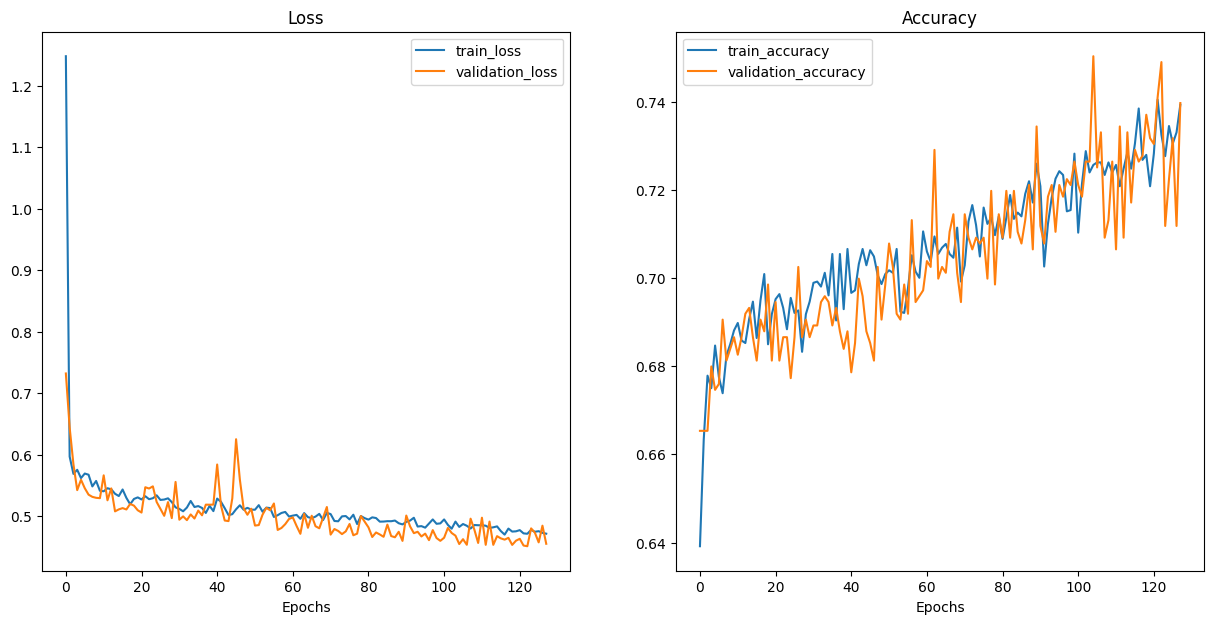

In [24]:
train_model(args)
